
# Import Packages

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [2]:
sys.path.append(os.path.abspath(os.path.join('../../..')))
from bayesflow.forward_inference import Prior, Simulator, GenerativeModel

# Introduction
<br>
In this tutorial, we will look at a simple linear ODE system:

<br><br>
$$
\frac{du}{dt} = a u + b v \\
\frac{dv}{dt} = c u + d v  
$$
<br><br>


with the boundary conditions:

<br><br>
$$
u(t=0) = u_0 \\
v(t=0) = v_0
$$
<br><br>

Given the solutions $u(t)$ and $v(t)$, we want to use BayesFlow to predict the parameters $a$, $b$, $c$ and $d$ of the ODE equations as well as the boundary conditions $u_0$ and $v_0$.  


# Analytical Solution

The advantage of such a simple ODE system is, that the analytical solutions for $u$ and $v$ are known:

<br><br>
$$
\begin{pmatrix}
    u \\
    v
\end{pmatrix}
= C_1 e^{\lambda_1 t} \vec{v_1} + C_2 e^{\lambda_2 t} \vec{v_2} = 
\begin{bmatrix}
    \vec{v_1} & \vec{v_2}
\end{bmatrix}
\begin{pmatrix}
    C_1 e^{\lambda_1 t} \\
    C_2 e^{\lambda_2 t}
\end{pmatrix}
$$
<br><br>

where $\lambda_1$ and $\lambda_2$ are eigenvalues and $\vec{v_1}$ and $\vec{v_2}$ are eigenvectors of the matrix:

<br><br>
$$
A=
\begin{pmatrix}
    a & b \\
    c & d \\
\end{pmatrix}
$$
<br><br>

$\begin{bmatrix} \vec{v_1} & \vec{v_2} \end{bmatrix}$ is the matrix, that has the eigenvectors $\vec{v_1}$ and $\vec{v_2}$ as its column vectors. 

<br><br>
The constants $C_1$ and $C_2$ can be computed from the boundary condition:

<br><br>
$$
\begin{pmatrix}
    C_1 \\
    C_2
\end{pmatrix}
=
\begin{bmatrix}
    \vec{v_1} & \vec{v_2}
\end{bmatrix}^{-1}
\begin{pmatrix}
    u_0 \\
    v_0
\end{pmatrix}
$$

# Stability of Solutions

The solution $u$ and $v$ will be of the form:

<br><br>
$$
u = v_{11} C_1 e^{\lambda_1 t} + v_{21} C_2 e^{\lambda_2 t} \\
v = v_{12} C_1 e^{\lambda_1 t} + v_{22} C_2 e^{\lambda_2 t}
$$
<br><br>

By separating the real and complex part of the eigenvalues $\lambda_i = \gamma + i \omega$ we see, that the real part affects if a solution will be exponential increasing/decreasing or stay constant, whereas the complex part will determine the oscillation behaviour. 

<br><br>
$$
u = v_{11} C_1 e^{\gamma_1 t} \left[ cos(\omega_1 t) + i sin(\omega_1 t) \right] + v_{21} C_2 e^{\gamma_2 t} \left[ cos(\omega_2 t) + i sin(\omega_2 t) \right] \\
v = v_{12} C_1 e^{\gamma_1 t} \left[ cos(\omega_1 t) + i sin(\omega_1 t) \right] + v_{22} C_2 e^{\gamma_2 t} \left[  cos(\omega_2 t) + i sin(\omega_2 t) \right]
$$
<br><br>

We will apply rejection sampling to only consider stable solutions, in other words solution that fulfill the condition $\gamma_1 \leq 0$ and $\gamma_2 \leq 0$.  

 # Generate Simulation Data with Rejection Sampling
 
We have to generate some simulation data to train our BayesFlow. The first step is to randomly draw combinations of $a$, $b$, $c$, $d$, $u_0$ and $v_0$ from a uniform prior distribution. Additionally, we estimate the prior means and standard deviations for normalization later.  

In [3]:
def model_prior():
    """Generates random draws from uniform pior with rejection sampling"""
    
    while True:
        # generate sample
        samples = np.random.uniform(low=-10, high=10, size=6)
        
        # reject, if solution not stable
        A = samples[:4].reshape((2, 2))
        eigenvalues, _ = np.linalg.eig(A)
        if eigenvalues[0].real <= 0 and eigenvalues[1].real <= 0:
            break
            
    return samples   

In [4]:
prior = Prior(prior_fun=model_prior, param_names=[r'$a$', r'$b$', r'$c$', r'$d$', r'$u_0$', r'$v_0$']) 
prior_means, prior_stds = prior.estimate_means_and_stds()

The next step is to generate simulation data from the prior samples by defining a simulator:

In [5]:
def linear_ode_solver(params, t):
    """Solves the linear ODE system analytically for given time points t and prior parameter samples"""
    
    # unpack params
    A = params[:4].reshape((2, 2))
    boundaries = params[-2:]
    
    # solve for u and v
    eigenvalues, eigenvectors = np.linalg.eig(A)
    C = np.linalg.inv(eigenvectors) @ boundaries
    solution = eigenvectors @ np.array([C[0] * np.exp(eigenvalues[0] * t), C[1] * np.exp(eigenvalues[1] * t)])
    
    return solution[0], solution[1]

In [21]:
time_points = np.linspace(0, 5, num=64)
simulator = Simulator(simulator_fun=partial(linear_ode_solver, t=time_points))

Finally, we will wrap the prior and simulator into a generative model for simuation data generation:

In [22]:
model = GenerativeModel(prior, simulator, name='linear_ODE_system')

INFO:root:Performing 2 pilot runs with the linear_ODE_system model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 2, 64)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


As a sanity check, we will sample 1000 prior combinations and visualize the joint priors in bivariate plots:

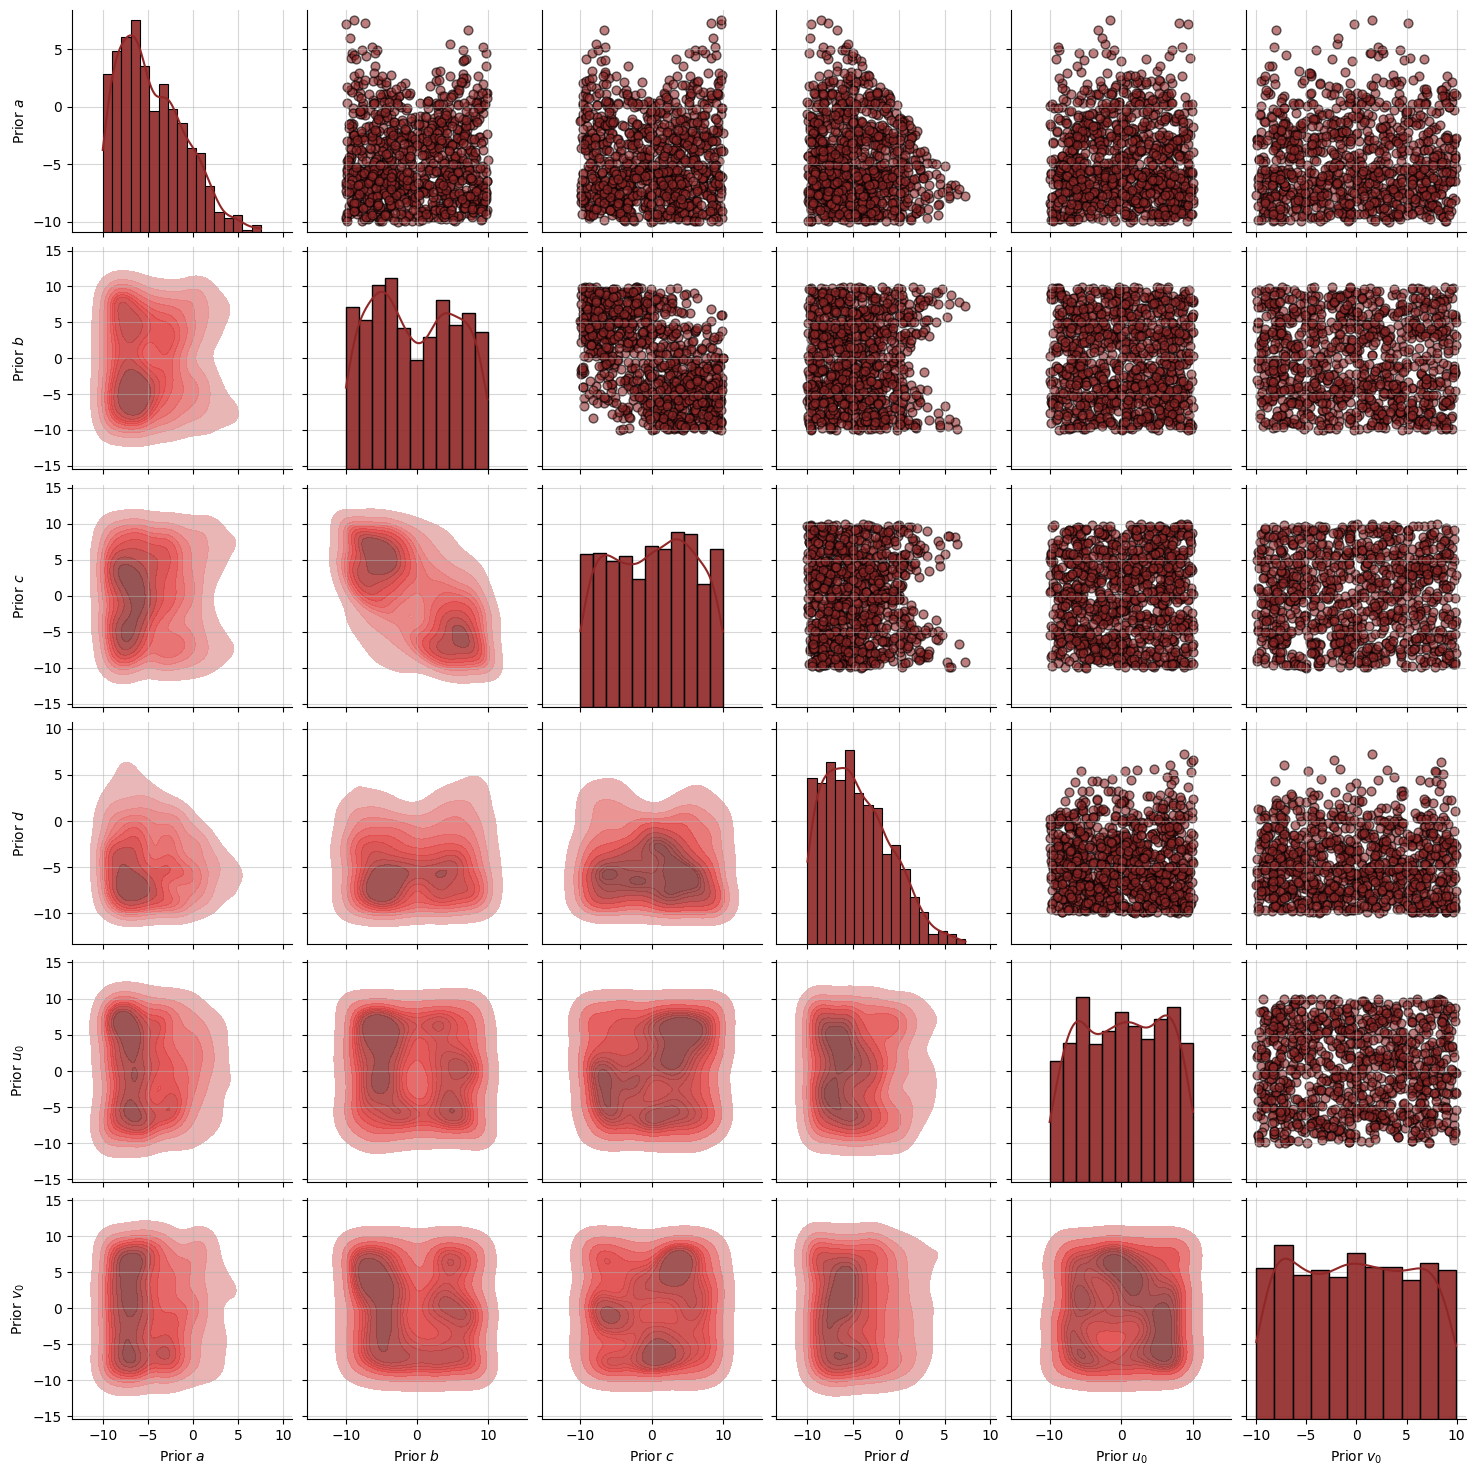

In [13]:
fig = prior.plot_prior2d()

Additionally, we can visualize the simulation data:

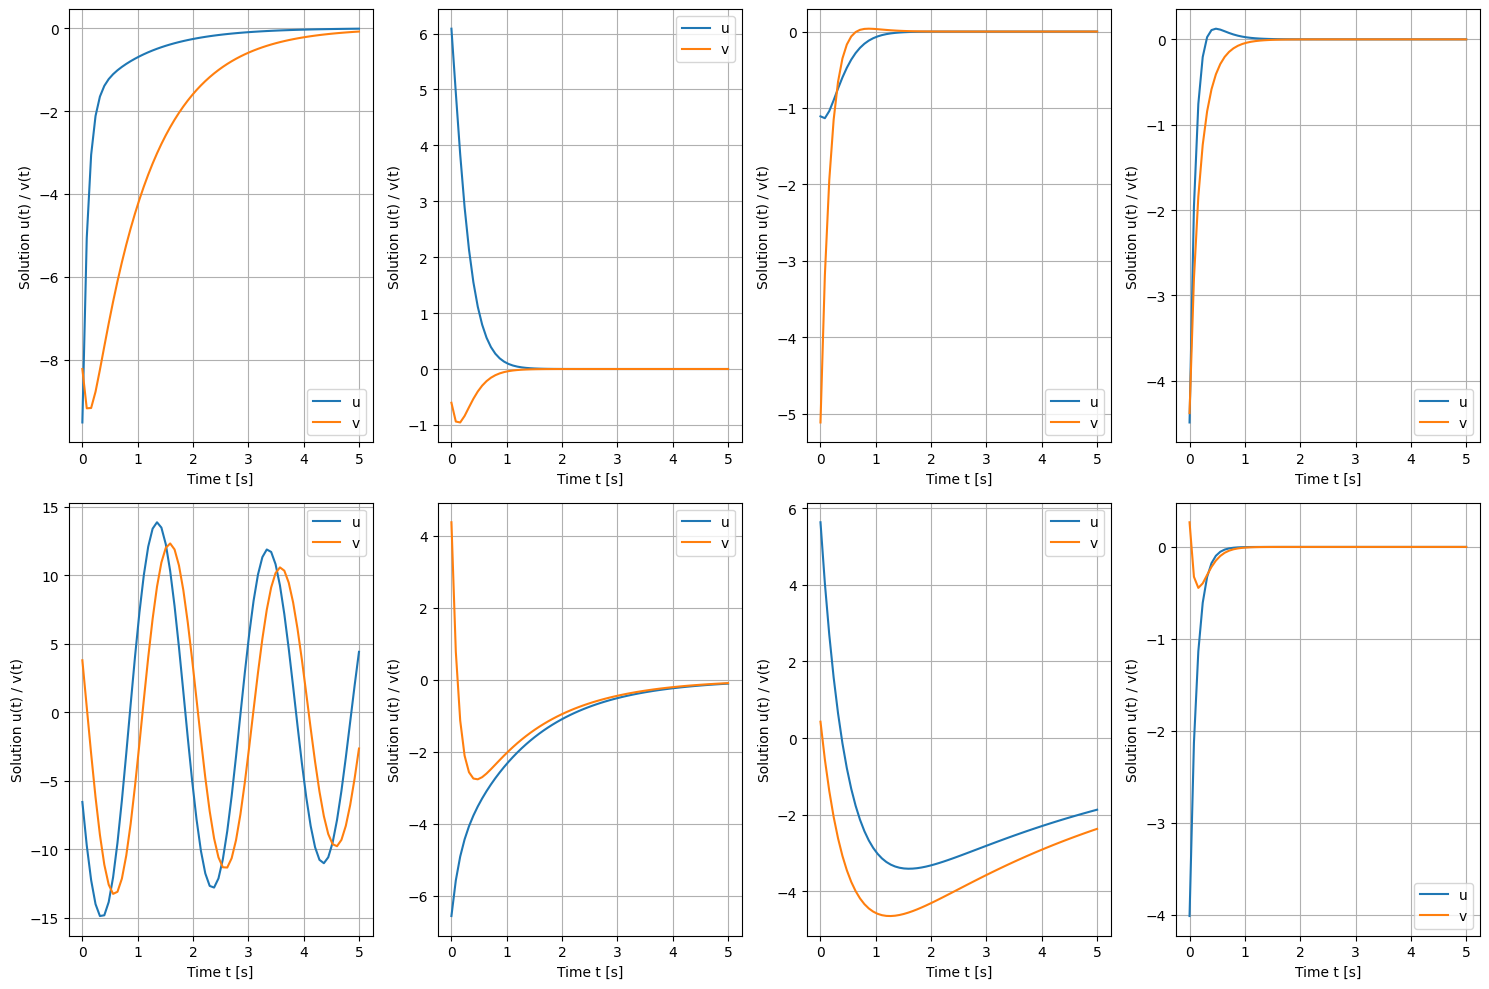

In [24]:
sim_data = model(8)['sim_data']
fig, ax = plt.subplots(2, 4, figsize=(15, 10))
ax = ax.flat

for i, data in enumerate(sim_data):
    ax[i].plot(time_points, data[0, :], label='u')
    ax[i].plot(time_points, data[1, :], label='v')
    ax[i].set_xlabel("Time t [s]")
    ax[i].set_ylabel("Solution u(t) / v(t)")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()